In [1]:
# Parte 1: Configuração do Ambiente
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os

In [2]:
# Estilo dos gráficos
plt.style.use('ggplot')
sns.set(style="whitegrid")

# Criar pasta para armazenar dados
if not os.path.exists('dados_cotacoes'):
    os.makedirs('dados_cotacoes')


In [3]:
# Parte 2: Coleta de Dados via API

# Período dos últimos 30 dias
data_fim = datetime.now().strftime('%m-%d-%Y')
data_inicio = (datetime.now() - timedelta(days=30)).strftime('%m-%d-%Y')

In [4]:
# Moedas a consultar
moedas = {
    'USD': 'Dólar Americano',
    'EUR': 'Euro',
    'GBP': 'Libra Esterlina',
    'JPY': 'Iene Japonês',
    'ARS': 'Peso Argentino'
}

# Armazenar os dados
dados_cotacoes = {}


In [5]:
# Consultar API do Banco Central
for codigo, nome in moedas.items():
    print(f"Consultando {nome} ({codigo})...")
    url = (
        f"https://olinda.bcb.gov.br/olinda/servico/PTAX/versao/v1/odata/"
        f"CotacaoMoedaPeriodo(moeda=@moeda,dataInicial=@dataInicial,dataFinalCotacao=@dataFinalCotacao)?"
        f"@moeda='{codigo}'&@dataInicial='{data_inicio}'&@dataFinalCotacao='{data_fim}'"
        f"&$top=100&$format=json"
    )
    response = requests.get(url)
    if response.status_code == 200:
        dados = response.json()
        if 'value' in dados and dados['value']:
            cotacoes = []
            for item in dados['value']:
                cotacoes.append({
                    'data': item['dataHoraCotacao'],
                    'cotacao_compra': item['cotacaoCompra'],
                    'cotacao_venda': item['cotacaoVenda']
                })
            dados_cotacoes[codigo] = {
                'nome': nome,
                'cotacoes': cotacoes
            }
            print(f" ✓ Obtidas {len(cotacoes)} cotações.")
        else:
            print(" ✗ Nenhum dado de cotação encontrado.")
    else:
        print(f" ✗ Erro ao acessar a API. Código: {response.status_code}")


Consultando Dólar Americano (USD)...
 ✓ Obtidas 100 cotações.
Consultando Euro (EUR)...
 ✓ Obtidas 100 cotações.
Consultando Libra Esterlina (GBP)...
 ✓ Obtidas 100 cotações.
Consultando Iene Japonês (JPY)...
 ✓ Obtidas 100 cotações.
Consultando Peso Argentino (ARS)...
 ✗ Nenhum dado de cotação encontrado.


In [6]:
# Parte 3: Processamento e Armazenamento dos Dados

for codigo, dados in dados_cotacoes.items():
    if dados['cotacoes']:
        df = pd.DataFrame(dados['cotacoes'])
        df['data'] = pd.to_datetime(df['data'])
        df = df.sort_values('data')
        arquivo_csv = f'dados_cotacoes/cotacao_{codigo}.csv'
        df.to_csv(arquivo_csv, index=False, encoding='utf-8-sig')
        print(f" ✓ Arquivo '{arquivo_csv}' criado com sucesso!")

 ✓ Arquivo 'dados_cotacoes/cotacao_USD.csv' criado com sucesso!
 ✓ Arquivo 'dados_cotacoes/cotacao_EUR.csv' criado com sucesso!
 ✓ Arquivo 'dados_cotacoes/cotacao_GBP.csv' criado com sucesso!
 ✓ Arquivo 'dados_cotacoes/cotacao_JPY.csv' criado com sucesso!


 ✓ Gráfico 'dados_cotacoes/grafico_todas_moedas.png' criado com sucesso!


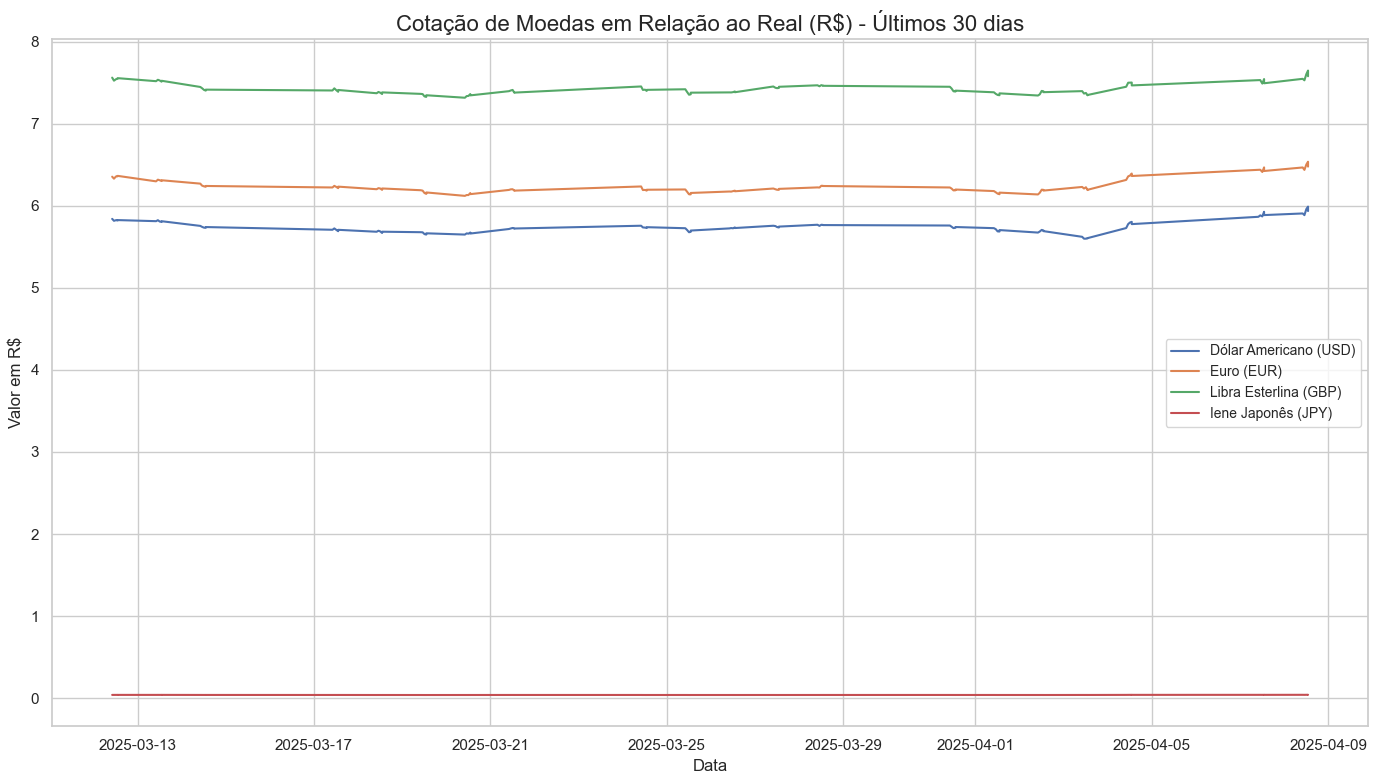

In [7]:
# Parte 4: Visualização dos Dados

# 1. Gráfico comparativo de todas as moedas
plt.figure(figsize=(14, 8))
for codigo, dados in dados_cotacoes.items():
    if dados['cotacoes']:
        df = pd.DataFrame(dados['cotacoes'])
        df['data'] = pd.to_datetime(df['data'])
        df = df.sort_values('data')
        plt.plot(df['data'], df['cotacao_venda'], label=f"{dados['nome']} ({codigo})")
plt.title('Cotação de Moedas em Relação ao Real (R$) - Últimos 30 dias', fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Valor em R$', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
arquivo_grafico = 'dados_cotacoes/grafico_todas_moedas.png'
plt.savefig(arquivo_grafico, dpi=300)
print(f" ✓ Gráfico '{arquivo_grafico}' criado com sucesso!")

 ✓ Gráfico 'dados_cotacoes/grafico_USD.png' criado com sucesso!
 ✓ Gráfico 'dados_cotacoes/grafico_EUR.png' criado com sucesso!
 ✓ Gráfico 'dados_cotacoes/grafico_GBP.png' criado com sucesso!
 ✓ Gráfico 'dados_cotacoes/grafico_JPY.png' criado com sucesso!


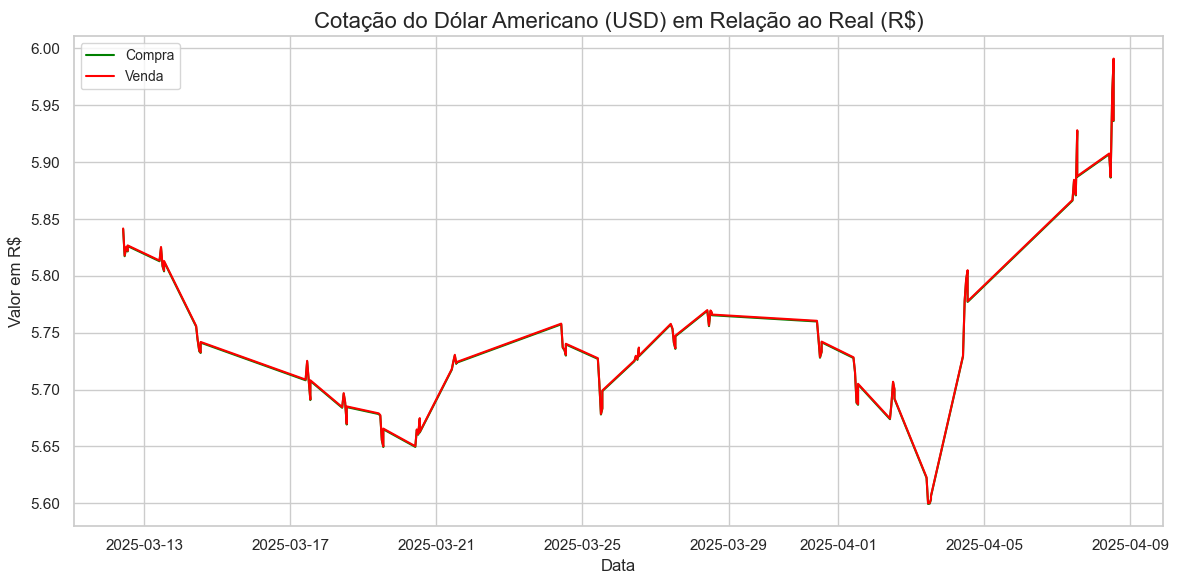

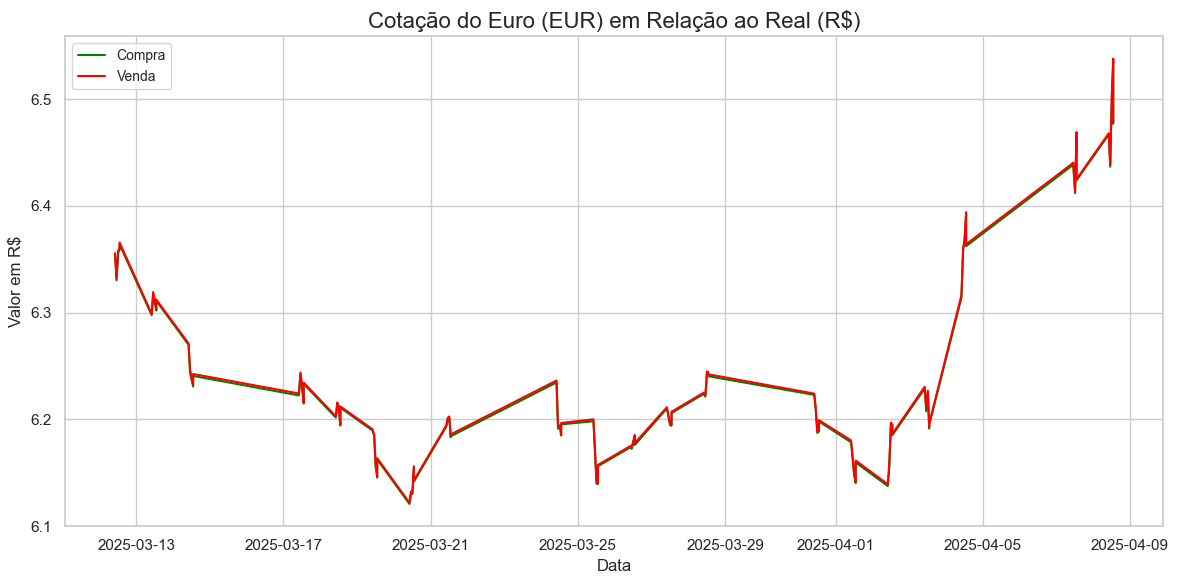

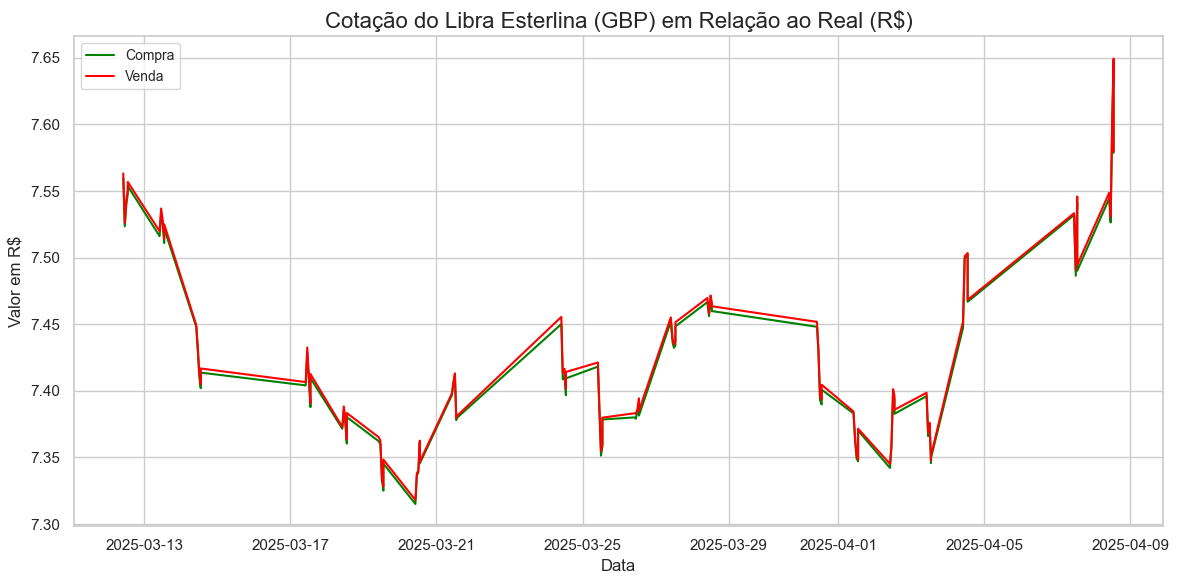

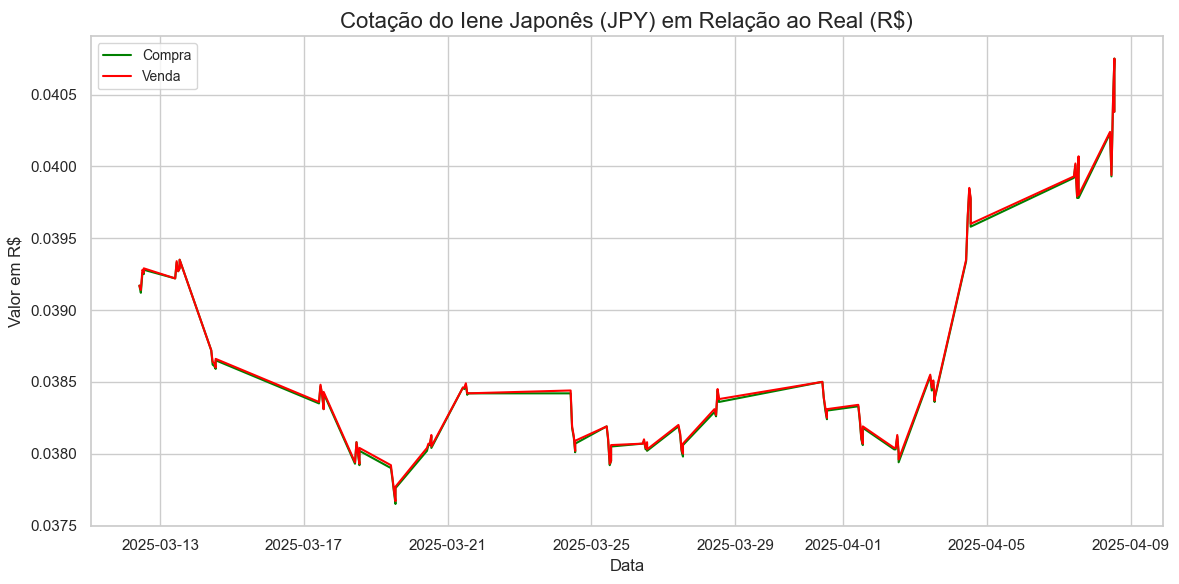

In [8]:
# 2. Gráficos individuais por moeda
for codigo, dados in dados_cotacoes.items():
    if dados['cotacoes']:
        plt.figure(figsize=(12, 6))
        df = pd.DataFrame(dados['cotacoes'])
        df['data'] = pd.to_datetime(df['data'])
        df = df.sort_values('data')
        plt.plot(df['data'], df['cotacao_compra'], label='Compra', color='green', linestyle='-')
        plt.plot(df['data'], df['cotacao_venda'], label='Venda', color='red', linestyle='-')
        plt.title(f'Cotação do {dados["nome"]} ({codigo}) em Relação ao Real (R$)', fontsize=16)
        plt.xlabel('Data', fontsize=12)
        plt.ylabel('Valor em R$', fontsize=12)
        plt.legend(fontsize=10)
        plt.grid(True)
        plt.tight_layout()
        arquivo_grafico = f'dados_cotacoes/grafico_{codigo}.png'
        plt.savefig(arquivo_grafico, dpi=300)
        print(f" ✓ Gráfico '{arquivo_grafico}' criado com sucesso!")

 ✓ Gráfico 'dados_cotacoes/grafico_variacao_percentual.png' criado com sucesso!


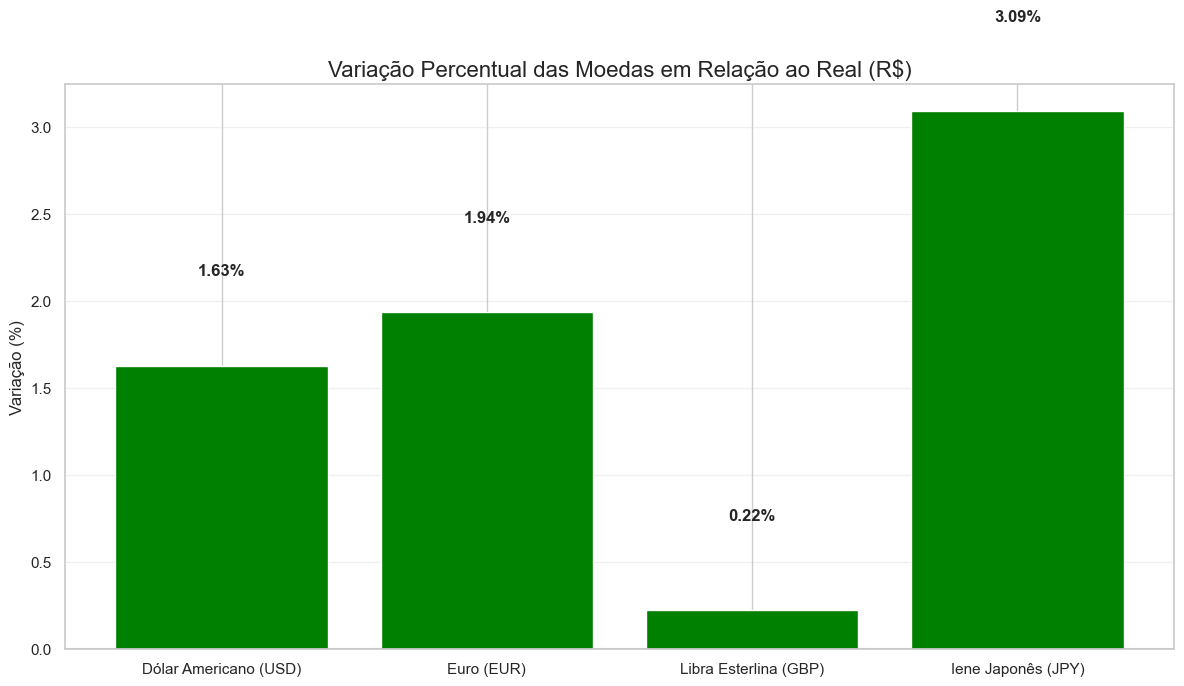

In [9]:
# 3. Gráfico de variação percentual
plt.figure(figsize=(12, 7))
variacoes = []
nomes = []
for codigo, dados in dados_cotacoes.items():
    if dados['cotacoes'] and len(dados['cotacoes']) >= 2:
        df = pd.DataFrame(dados['cotacoes'])
        df['data'] = pd.to_datetime(df['data'])
        df = df.sort_values('data')
        primeiro_valor = df.iloc[0]['cotacao_venda']
        ultimo_valor = df.iloc[-1]['cotacao_venda']
        variacao_pct = ((ultimo_valor - primeiro_valor) / primeiro_valor) * 100
        variacoes.append(variacao_pct)
        nomes.append(f"{dados['nome']} ({codigo})")
cores = ['green' if var >= 0 else 'red' for var in variacoes]
plt.bar(nomes, variacoes, color=cores)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
for i, v in enumerate(variacoes):
    plt.text(i, v + (0.5 if v >= 0 else -1.5), f"{v:.2f}%",
             ha='center', va='bottom' if v >= 0 else 'top', fontweight='bold')
plt.title('Variação Percentual das Moedas em Relação ao Real (R$)', fontsize=16)
plt.ylabel('Variação (%)', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
arquivo_grafico = 'dados_cotacoes/grafico_variacao_percentual.png'
plt.savefig(arquivo_grafico, dpi=300)
print(f" ✓ Gráfico '{arquivo_grafico}' criado com sucesso!")


In [11]:
# Parte 5: Resumo dos Dados Coletados
print("\nResumo dos dados coletados:")
for codigo, dados in dados_cotacoes.items():
    if dados['cotacoes']:
        df = pd.DataFrame(dados['cotacoes'])
        df['data'] = pd.to_datetime(df['data'])  # ✅ Conversão para datetime
        print(f"\n{dados['nome']} ({codigo}):")
        print(f" - Período: {df['data'].min().strftime('%d/%m/%Y')} a {df['data'].max().strftime('%d/%m/%Y')}")
        print(f" - Cotação mínima: R$ {df['cotacao_venda'].min():.4f}")
        print(f" - Cotação máxima: R$ {df['cotacao_venda'].max():.4f}")
        print(f" - Cotação média: R$ {df['cotacao_venda'].mean():.4f}")


Resumo dos dados coletados:

Dólar Americano (USD):
 - Período: 12/03/2025 a 08/04/2025
 - Cotação mínima: R$ 5.6000
 - Cotação máxima: R$ 5.9911
 - Cotação média: R$ 5.7429

Euro (EUR):
 - Período: 12/03/2025 a 08/04/2025
 - Cotação mínima: R$ 6.1220
 - Cotação máxima: R$ 6.5381
 - Cotação média: R$ 6.2431

Libra Esterlina (GBP):
 - Período: 12/03/2025 a 08/04/2025
 - Cotação mínima: R$ 7.3181
 - Cotação máxima: R$ 7.6494
 - Cotação média: R$ 7.4290

Iene Japonês (JPY):
 - Período: 12/03/2025 a 08/04/2025
 - Cotação mínima: R$ 0.0377
 - Cotação máxima: R$ 0.0408
 - Cotação média: R$ 0.0386



Análise de Correlação entre Moedas:
          USD       EUR       GBP       JPY
USD  1.000000  0.887662  0.924821  0.855745
EUR  0.887662  1.000000  0.914826  0.967147
GBP  0.924821  0.914826  1.000000  0.876599
JPY  0.855745  0.967147  0.876599  1.000000
 ✓ Gráfico de correlação 'dados_cotacoes/correlacao_moedas.png' criado com sucesso!


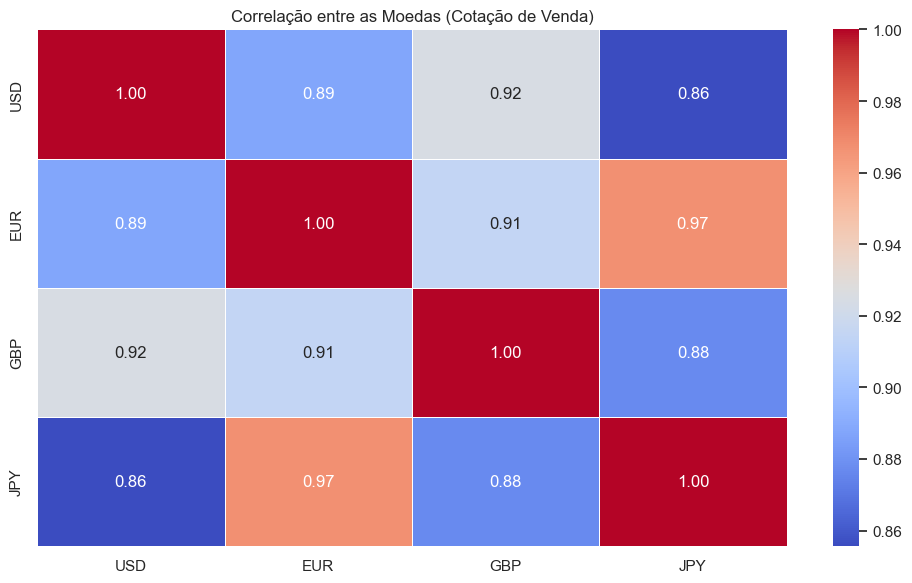

In [12]:
# Parte 6: Análise de Correlação entre Moedas

print("\nAnálise de Correlação entre Moedas:")

# Criar um DataFrame base para juntar os dados
df_cotacoes = pd.DataFrame()

for codigo, dados in dados_cotacoes.items():
    if dados['cotacoes']:
        df_temp = pd.DataFrame(dados['cotacoes'])
        df_temp['data'] = pd.to_datetime(df_temp['data'])
        df_temp = df_temp.set_index('data').sort_index()
        df_cotacoes[codigo] = df_temp['cotacao_venda']

# Eliminar datas faltantes
df_cotacoes = df_cotacoes.dropna()

# Calcular correlação
correlacoes = df_cotacoes.corr()

# Exibir matriz de correlação
print(correlacoes)

# Visualizar com mapa de calor
plt.figure(figsize=(10, 6))
sns.heatmap(correlacoes, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title('Correlação entre as Moedas (Cotação de Venda)')
plt.tight_layout()

arquivo_correlacao = 'dados_cotacoes/correlacao_moedas.png'
plt.savefig(arquivo_correlacao, dpi=300)
print(f" ✓ Gráfico de correlação '{arquivo_correlacao}' criado com sucesso!")


In [13]:
# Parte 7: Relatório Final com Conclusões

print("\nRelatório e Conclusões:")

relatorio = []

for codigo, dados in dados_cotacoes.items():
    if dados['cotacoes']:
        df = pd.DataFrame(dados['cotacoes'])
        df['data'] = pd.to_datetime(df['data'])
        df = df.sort_values('data')

        valor_inicial = df.iloc[0]['cotacao_venda']
        valor_final = df.iloc[-1]['cotacao_venda']
        variacao = ((valor_final - valor_inicial) / valor_inicial) * 100

        direcao = "valorização" if variacao > 0 else "desvalorização"
        conclusao = f"A moeda {dados['nome']} ({codigo}) teve uma {direcao} de {variacao:.2f}% no período de {df['data'].min().strftime('%d/%m/%Y')} a {df['data'].max().strftime('%d/%m/%Y')}."
        print(" - " + conclusao)
        relatorio.append(conclusao)

# Salvar o relatório em texto
arquivo_relatorio = "dados_cotacoes/relatorio_conclusoes.txt"
with open(arquivo_relatorio, "w", encoding="utf-8") as f:
    f.write("Relatório de Análise das Cotações das Moedas (últimos 30 dias)\n")
    f.write("="*60 + "\n\n")
    for item in relatorio:
        f.write("- " + item + "\n")

print(f"\n ✓ Relatório final salvo em '{arquivo_relatorio}'")



Relatório e Conclusões:
 - A moeda Dólar Americano (USD) teve uma valorização de 1.63% no período de 12/03/2025 a 08/04/2025.
 - A moeda Euro (EUR) teve uma valorização de 1.94% no período de 12/03/2025 a 08/04/2025.
 - A moeda Libra Esterlina (GBP) teve uma valorização de 0.22% no período de 12/03/2025 a 08/04/2025.
 - A moeda Iene Japonês (JPY) teve uma valorização de 3.09% no período de 12/03/2025 a 08/04/2025.

 ✓ Relatório final salvo em 'dados_cotacoes/relatorio_conclusoes.txt'
